In [ ]:
!pip install spacy


In [ ]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 145.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
import numpy as np
import spacy
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

dataset = "/content/drive/MyDrive/datasets/semeval-data/TRAIN_FILE.TXT"

In [ ]:
import os
target_dir = '/content/drive/MyDrive/datasets/glove'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    print(f"Created directory: {target_dir}")
else:
    print(f"Directory already exists: {target_dir}")

Created directory: /content/drive/MyDrive/datasets/glove


In [ ]:
%cd $target_dir

!if [ ! -f glove.6B.zip ]; then \
  wget http://nlp.stanford.edu/data/glove.6B.zip; \
fi

!unzip -n glove.6B.zip

/content/drive/MyDrive/datasets/glove
--2025-12-07 19:46:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-07 19:46:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-07 19:46:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [applicatio

In [ ]:
NUM_CLASSES = 19
MAX_LEN = 100
EMBED_DIM = 300
EPOCHS = 60
BATCH_SIZE = 16
LR = 0.0008

POS_EMBED_DIM = 20


In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
sentences, raw_labels, e1_indices, e2_indices = load_data_and_clean(dataset)

In [ ]:
vocab = {"<PAD>": 0, "<UNK>": 1}
X_ids = []
X_adj = []
X_d1 = []
X_d2 = []


for i, sent in enumerate(sentences):
    # 1. Parse ONCE
    doc = nlp(sent)

    # 2. Build IDs
    seq_ids = []
    for token in doc:
        if token.text not in vocab:
            vocab[token.text] = len(vocab)
        seq_ids.append(vocab[token.text])

    # Pad IDs
    if len(seq_ids) > MAX_LEN:
        seq_ids = seq_ids[:MAX_LEN]
    else:
        seq_ids = seq_ids + [0] * (MAX_LEN - len(seq_ids))
    X_ids.append(seq_ids)

    # Adjacency Matrix
    adj = np.zeros((MAX_LEN, MAX_LEN))
    valid_len = min(len(doc), MAX_LEN)

    # Dependency Connections
    for token in doc[:valid_len]:
        adj[token.i, token.i] = 1
        # Connect dependent to head
        if token.head.i < MAX_LEN and token.i != token.head.i:
            adj[token.i, token.head.i] = 1
            adj[token.head.i, token.i] = 1

    e1 = e1_indices[i]
    e2 = e2_indices[i]
    if e1 < MAX_LEN and e2 < MAX_LEN:
        adj[e1, e2] = 1
        adj[e2, e1] = 1

    X_adj.append(adj)

    # Distance Features
    d1 = []
    d2 = []
    for j in range(MAX_LEN):
        dist_a = j - e1 + MAX_LEN
        dist_b = j - e2 + MAX_LEN
        d1.append(max(0, min(dist_a, 2*MAX_LEN)))
        d2.append(max(0, min(dist_b, 2*MAX_LEN)))
    X_d1.append(d1)
    X_d2.append(d2)

# Convert to Numpy Arrays
X_ids = np.array(X_ids, dtype='int32')
X_adj = np.array(X_adj, dtype='float32')
X_d1 = np.array(X_d1, dtype='int32')
X_d2 = np.array(X_d2, dtype='int32')

X_e1_idx = np.clip(X_e1_idx, 0, MAX_LEN - 1)
X_e2_idx = np.clip(X_e2_idx, 0, MAX_LEN - 1)
le = LabelEncoder()
y_ints = le.fit_transform(raw_labels)
y_onehot = to_categorical(y_ints)
NUM_CLASSES = len(le.classes_)
VOCAB_SIZE = len(vocab)


Processing dependency trees with Entity Shortcuts...
X_ids shape: (8000, 100)
X_adj shape: (8000, 100, 100)


In [ ]:
def get_embedding_matrix(word_index, embed_dim=300):
    glove_path = '/content/drive/MyDrive/datasets/glove/glove.6B.300d.txt'
    embeddings_index = {}
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Matrix
    vocab_size = len(word_index)
    embedding_matrix = np.zeros((vocab_size, embed_dim))

    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        elif embedding_vector is None and word.lower() in embeddings_index:
             embedding_matrix[i] = embeddings_index[word.lower()]
        else:
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embed_dim,))

    return embedding_matrix


In [ ]:
embedding_matrix = get_embedding_matrix(vocab, EMBED_DIM)

In [ ]:
from tensorflow.keras import layers, models, regularizers, initializers
import tensorflow as tf

class GraphAttentionLayer(layers.Layer):

    def __init__(self, units, num_heads=4, dropout_rate=0.2, **kwargs):
        super(GraphAttentionLayer, self).__init__(**kwargs)
        self.units = units
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        feature_dim = input_shape[0][-1]

        # Weights for transforming features
        self.kernels = [self.add_weight(name=f'W_{i}',
                                      shape=(feature_dim, self.units),
                                      initializer='glorot_uniform',
                                      trainable=True)
                        for i in range(self.num_heads)]

        # Attention mechanisms
        self.att_kernels = [self.add_weight(name=f'attn_{i}',
                                          shape=(2 * self.units, 1),
                                          initializer='glorot_uniform',
                                          trainable=True)
                            for i in range(self.num_heads)]

        self.leaky_relu = layers.LeakyReLU(negative_slope=0.2)
        self.dropout = layers.Dropout(self.dropout_rate)

    def call(self, inputs):
        h, adj = inputs

        outputs = []
        for i in range(self.num_heads):

            wh = tf.matmul(h, self.kernels[i])

            # pairs of all nodes
            wh_i = tf.expand_dims(wh, 2)
            wh_j = tf.expand_dims(wh, 1)

            concat = tf.concat([
                tf.tile(wh_i, [1, 1, MAX_LEN, 1]),
                tf.tile(wh_j, [1, MAX_LEN, 1, 1])
            ], axis=-1)

            # Compute energy
            e = tf.matmul(concat, self.att_kernels[i])
            e = tf.squeeze(e, axis=-1)
            e = self.leaky_relu(e)

            # Mask with Adjacency
            zero_vec = -1e9 * tf.ones_like(e)
            attention = tf.where(adj > 0, e, zero_vec)

            # Softmax
            attention = tf.nn.softmax(attention, axis=-1)
            attention = self.dropout(attention)

            # Output
            head_out = tf.matmul(attention, wh)
            outputs.append(head_out)

        # Concat heads
        output = layers.Concatenate()(outputs)
        return output

In [ ]:
class EntityGatherLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(EntityGatherLayer, self).__init__(**kwargs)

    def call(self, inputs):
        features, indices = inputs
        return tf.gather(features, indices, batch_dims=1)

    def get_config(self):
        return super(EntityGatherLayer, self).get_config()

In [ ]:
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    gamma: Focus on hard samples (higher = more focus on errors)
    alpha: Balance 'Other' class vs specific relations
    """
    def focal_loss_fixed(y_true, y_pred):
        y_pred /= tf.reduce_sum(y_pred, axis=-1, keepdims=True)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return focal_loss_fixed

In [ ]:
def build_regularized_gat():
    # Inputs
    input_ids = layers.Input(shape=(MAX_LEN,), name='ids', dtype='int32')
    input_adj = layers.Input(shape=(MAX_LEN, MAX_LEN), name='adj', dtype='float32')
    input_d1 = layers.Input(shape=(MAX_LEN,), name='d1', dtype='int32')
    input_d2 = layers.Input(shape=(MAX_LEN,), name='d2', dtype='int32')
    input_e1_idx = layers.Input(shape=(), name='e1_idx', dtype='int32')
    input_e2_idx = layers.Input(shape=(), name='e2_idx', dtype='int32')

    # Embeddings
    emb_word = layers.Embedding(VOCAB_SIZE, EMBED_DIM,
                                weights=[embedding_matrix],
                                trainable=True)(input_ids)

    # DROPOUT 1
    x = layers.SpatialDropout1D(0.3)(emb_word)

    pos_vocab_size = 2 * MAX_LEN + 1
    emb_d1 = layers.Embedding(pos_vocab_size, POS_EMBED_DIM)(input_d1)
    emb_d2 = layers.Embedding(pos_vocab_size, POS_EMBED_DIM)(input_d2)

    x = layers.Concatenate()([x, emb_d1, emb_d2])

    # Encoder (BiLSTM)
    h_seq = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.0))(x)

    # GAT Layers
    gat1 = GraphAttentionLayer(units=128, num_heads=4, dropout_rate=0.4)([h_seq, input_adj])

    # Residual & Norm
    res_proj = layers.Dense(128 * 4)(h_seq)
    h_gat1 = layers.Add()([gat1, res_proj])
    h_gat1 = layers.LayerNormalization()(h_gat1)
    h_gat1 = layers.Activation('relu')(h_gat1)

    # Output GAT
    gat_out = GraphAttentionLayer(units=64, num_heads=4, dropout_rate=0.4)([h_gat1, input_adj])

    # Entity Gathering
    e1_state = EntityGatherLayer(name='gather_e1')([gat_out, input_e1_idx])
    e2_state = EntityGatherLayer(name='gather_e2')([gat_out, input_e2_idx])

    # Pooling & Interaction
    avg_pool = layers.GlobalAveragePooling1D()(gat_out)
    max_pool = layers.GlobalMaxPooling1D()(gat_out)


    e1_e2_mult = layers.Multiply()([e1_state, e2_state])

    final_rep = layers.Concatenate()([avg_pool, max_pool, e1_state, e2_state, e1_e2_mult])

    # Classifier with L2 Regularization
    features = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(final_rep)
    features = layers.Dropout(0.5)(features)

    output = layers.Dense(NUM_CLASSES, activation='softmax')(features)

    model = models.Model(
        inputs=[input_ids, input_adj, input_d1, input_d2, input_e1_idx, input_e2_idx],
        outputs=output
    )
    return model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

unique_labels, counts = np.unique(y_ints, return_counts=True)
underrepresented_labels = unique_labels[counts <= 1]

# Indices for classes that can be stratified (count > 1)
is_stratifiable = ~np.isin(y_ints, underrepresented_labels)
stratifiable_indices = np.where(is_stratifiable)[0]

# Indices for rare classes (count <= 1)
rare_indices = np.where(~is_stratifiable)[0]

y_stratifiable = y_ints[stratifiable_indices]


train_split_idx_local, val_split_idx_local = train_test_split(
    np.arange(len(stratifiable_indices)),
    test_size=0.1,
    random_state=42,
    stratify=y_stratifiable
)


train_split_idx_global = stratifiable_indices[train_split_idx_local]
X_val_idx = stratifiable_indices[val_split_idx_local]


X_train_idx = np.concatenate([train_split_idx_global, rare_indices])


y_train = y_ints[X_train_idx]
y_val = y_ints[X_val_idx]

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))


y_train_oh = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_oh = to_categorical(y_val, num_classes=NUM_CLASSES)


In [ ]:
unique_labels, counts = np.unique(y_ints, return_counts=True)
underrepresented = unique_labels[counts <= 1]
is_stratifiable = ~np.isin(y_ints, underrepresented)
strat_indices = np.where(is_stratifiable)[0]
rare_indices = np.where(~is_stratifiable)[0]

train_idx_local, val_idx_local = train_test_split(
    np.arange(len(strat_indices)), test_size=0.1, random_state=42, stratify=y_ints[strat_indices]
)
train_idx = np.concatenate([strat_indices[train_idx_local], rare_indices])
val_idx = strat_indices[val_idx_local]

In [ ]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau

tf.keras.backend.clear_session()

model = build_regularized_gat()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
              loss=categorical_focal_loss(gamma=3.5, alpha=0.25),
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ids (InputLayer)    │ (None, 100)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 300)  │  6,317,400 │ ids[0][0]         │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d1 (InputLayer)     │ (None, 100)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d2 (InputLayer)     │ (None, 100)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 100, 300)  │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 20)   │      4,020 │ d1[0][0]          │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 20)   │      4,020 │ d2[0][0]          │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100, 340)  │          0 │ spatial_dropout1… │
│ (Concatenate)       │                   │            │ embedding_1[0][0… │
│                     │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 512)  │  1,222,656 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adj (InputLayer)    │ (None, 100, 100)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_attention_la… │ (None, 100, 512)  │    263,168 │ bidirectional[0]… │
│ (GraphAttentionLay… │                   │            │ adj[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 512)  │    262,656 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 512)  │          0 │ graph_attention_… │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 512)  │      1,024 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 100, 512)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_attention_la… │ (None, 100, 256)  │    131,584 │ activation[0][0], │
│ (GraphAttentionLay… │                   │            │ adj[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e1_idx (InputLayer) │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e2_idx (InputLayer) │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gather_e1           │ (None, 256)       │          0 │ graph_attention_

 Total params: 8,872,147 (33.84 MB)

 Trainable params: 8,872,147 (33.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    [
        X_ids[train_idx], X_adj[train_idx], X_d1[train_idx], X_d2[train_idx],
        X_e1_idx[train_idx], X_e2_idx[train_idx]
    ],
    y_onehot[train_idx],
    validation_data=(
        [
            X_ids[val_idx], X_adj[val_idx], X_d1[val_idx], X_d2[val_idx],
            X_e1_idx[val_idx], X_e2_idx[val_idx]
        ],
        y_onehot[val_idx]
    ),
    epochs=60,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler]
)

Starting Training...
Epoch 1/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 138ms/step - accuracy: 0.1703 - loss: 1.2319 - val_accuracy: 0.4913 - val_loss: 0.6225 - learning_rate: 8.0000e-04
Epoch 2/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - accuracy: 0.3956 - loss: 0.6324 - val_accuracy: 0.5888 - val_loss: 0.3790 - learning_rate: 8.0000e-04
Epoch 3/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - accuracy: 0.5280 - loss: 0.3833 - val_accuracy: 0.6363 - val_loss: 0.2483 - learning_rate: 8.0000e-04
Epoch 4/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - accuracy: 0.5907 - loss: 0.2603 - val_accuracy: 0.6637 - val_loss: 0.1914 - learning_rate: 8.0000e-04
Epoch 5/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - accuracy: 0.6320 - loss: 0.1939 - val_accuracy: 0.7000 - val_loss: 0.1566 - learning_rate: 8.0000e-04
Epoch 6/60
225/225 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - accuracy: 0.6696 - loss: 0.1510 - val_accuracy: 0.7013 - val_loss: 0.1360 - learning_rate: 8.0000e-04
Epoch 7/60
225/225 ━━━━━━

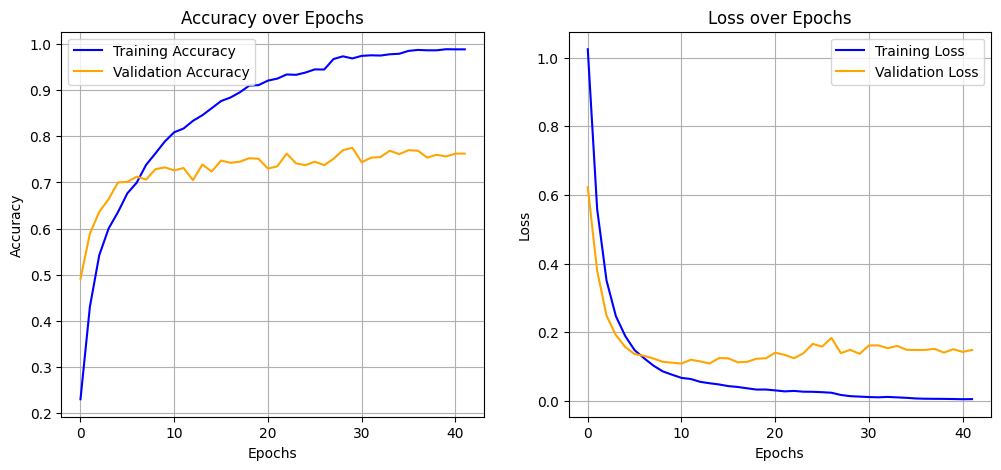

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    metrics = history.history

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(metrics['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(metrics['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(metrics['loss'], label='Training Loss', color='blue')
    plt.plot(metrics['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_training_history(history)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

all_labels = np.arange(len(le.classes_))
y_pred_probs = model.predict([
    X_ids[val_idx], X_adj[val_idx], X_d1[val_idx], X_d2[val_idx],
    X_e1_idx[val_idx], X_e2_idx[val_idx]
])

THRESHOLD = 0.2
other_idx = le.transform(["Other"])[0]

y_pred_ids = np.argmax(y_pred_probs, axis=1)
confidences = np.max(y_pred_probs, axis=1)

for i in range(len(y_pred_ids)):
    if confidences[i] < THRESHOLD:
        y_pred_ids[i] = other_idx

y_true_ids = np.argmax(y_onehot[val_idx], axis=1)

print(classification_report(
    y_true_ids,
    y_pred_ids,
    target_names=le.classes_,
    labels=all_labels,
    zero_division=0
))

Generating predictions...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Final Accuracy (with Threshold 0.7): 0.7250
------------------------------
                           precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.93      0.82      0.88        34
      Cause-Effect(e2,e1)       0.84      0.82      0.83        66
   Component-Whole(e1,e2)       0.86      0.81      0.84        47
   Component-Whole(e2,e1)       0.77      0.51      0.62        47
 Content-Container(e1,e2)       0.82      0.84      0.83        37
 Content-Container(e2,e1)       0.93      0.82      0.88        17
Entity-Destination(e1,e2)       0.92      0.79      0.85        85
Entity-Destination(e2,e1)       0.00      0.00      0.00         0
     Entity-Origin(e1,e2)       0.91      0.54      0.68        57
     Entity-Origin(e2,e1)       0.92      0.80      0.86        15
 Instrument-Agency(e1,e2)       1.00      0.70      0.82        10
 Instrument-Agency(e2,e1)       0.74      0.68      0.

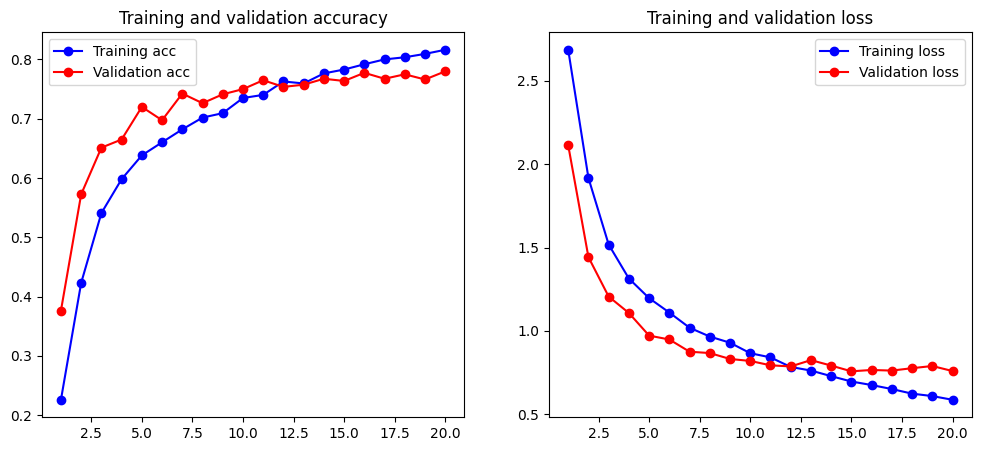

In [ ]:
plot_history(history)